# InceptionV3

### InceptionV3 with only 2 categories (US and non-US)

## Get packages

In [96]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
import albumentations as A 
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras import models
from keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

## Paths

In [97]:
TRAIN_PATH = 'archive/classification/us/train'
TEST_PATH = 'archive/classification/us/test'
VALID_PATH = 'archive/classification/us/validate'

In [98]:
input_size = (3,150,150)

## Load and Prepare the Images

In [142]:

# # divisible with 520: 2, 4, 5, 8, 10, 13, 20, 26, 40, 52, 65, 104, 130, 260
train_batchsize = 52
# # divisible with 104: 2, 4, 8, 13, 26, 52
valid_batchsize = 13

train_datagen = ImageDataGenerator(
        rescale = 1./255.,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=0.6
)

validation_datagen = ImageDataGenerator(
        rescale = 1./255.,
    )
                                  

train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,  
        shuffle=True,
         batch_size=train_batchsize,
        target_size = (150, 150),
        class_mode='categorical')  

validation_generator = validation_datagen.flow_from_directory(
        VALID_PATH,  
        target_size = (150, 150),
        shuffle=True,
         batch_size=valid_batchsize,
        class_mode='categorical')

Found 520 images belonging to 2 classes.
Found 104 images belonging to 2 classes.


## Make the model

In [143]:

from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

In [144]:
for layer in base_model.layers:
    layer.trainable = False

In [145]:
# from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(base_model)


model.add(Flatten())
model.add(Dense(1024,kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))  # Dropout for regularization

# Add a final sigmoid layer with 1 node for classification output
model.add(Dense(2, activation='softmax'))
# Print a summary of the model architecture
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_17 (Flatten)        (None, 18432)             0         
                                                                 
 dense_31 (Dense)            (None, 1024)              18875392  
                                                                 
 activation_1237 (Activatio  (None, 1024)              0         
 n)                                                              
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_32 (Dense)            (None, 2)                 2050      
                                                     

In [146]:
model.compile(
#     loss=keras.losses.CategoricalCrossentropy(),
    loss=keras.losses.BinaryFocalCrossentropy(),
    optimizer = keras.optimizers.legacy.RMSprop(learning_rate=0.001, decay=1e-03, momentum=0.9),  
    metrics = ['accuracy'])

## Train the model

In [147]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.Variable) or tf.is_tensor(lr):
            lr = tf.keras.backend.get_value(lr)
        print(f" Epoch {epoch+1}: Learning rate is {lr:.6f}")

In [148]:
# Saving the best result
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_us_inception.h5', verbose=1, save_best_only=True)
steps = train_generator.samples//train_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001, verbose=1)

callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    reduce_lr,
    LearningRateLogger(),
    checkpoiter

]
# Train
results = model.fit(train_generator, 
                   validation_data=validation_generator, 
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    steps_per_epoch = steps,
                    shuffle=True,
                    batch_size=64,
                    epochs=10, 
                    callbacks=callbacks,

                   )

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 17.9293 - accuracy: 0.9442

/Users/taras_lara/anaconda3/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 Epoch 1: Learning rate is 0.001000

Epoch 1: val_loss improved from inf to 16.37815, saving model to model_us_inception.h5


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 10s 901ms/step - loss: 17.9293 - accuracy: 0.9442 - val_loss: 16.3781 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 11.0692 - accuracy: 0.9865 Epoch 2: Learning rate is 0.001000

Epoch 2: val_loss improved from 16.37815 to 4.60245, saving model to model_us_inception.h5
10/10 [==============================] - 8s 803ms/step - loss: 11.0692 - accuracy: 0.9865 - val_loss: 4.6025 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 12.3945 - accuracy: 0.9462 Epoch 3: Learning rate is 0.001000

Epoch 3: val_loss did not improve from 4.60245
10/10 [==============================] - 8s 729ms/step - loss: 12.3945 - accuracy: 0.9462 - val_loss: 17.1848 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 16.2565 - accuracy: 0.9962 Epoch 4: Learning rate is 0.001000

Epoch 4: val_loss did not impro

## Results

In [114]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))

print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  1.0
Loss Score =  0.0


### During training

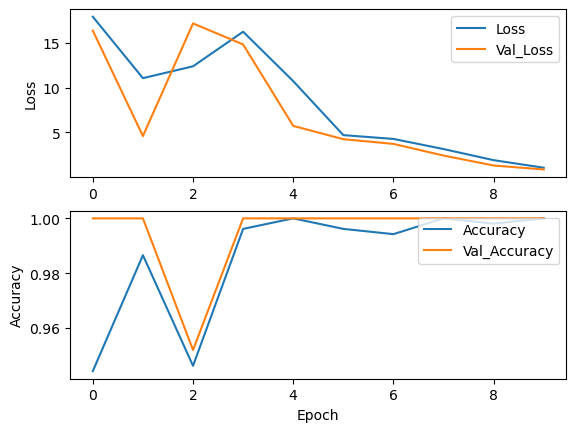

In [149]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Test the model

In [150]:
# divisible with 70: 2, 5, 7, 10, 14, 35 
test_batch_size = 10
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=input_size[1:],
    batch_size=test_batch_size,
    shuffle=False,
class_mode='categorical')
scores = model.evaluate(test_generator,workers=12)
print(scores)

Found 70 images belonging to 2 classes.
7/7 [==============================] - 1s 119ms/step - loss: 0.8660 - accuracy: 1.0000
[0.8660480380058289, 1.0]


In [163]:
target_names = list(test_generator.class_indices.keys())
print(target_names)


['US', 'non-US']


In [265]:
len(test_generator.classes)

64

### Make prediction

In [151]:
test_generator.reset()
Y_pred = model.predict(test_generator, verbose=1)
classes = test_generator.classes
y_pred = np.argmax(Y_pred, axis=-1)
print(classes)
print(y_pred)
print(sum(y_pred==classes)/len(test_generator.classes))
confusion_matrix(classes,y_pred)

7/7 [==============================] - 1s 110ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
1.0


array([[35,  0],
       [ 0, 35]])

### Confusion Matrix

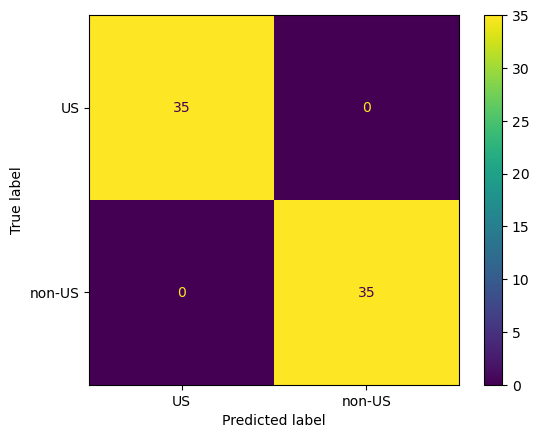

In [153]:
# Confusion Matrix
cm = confusion_matrix(classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot()
plt.grid(False)
plt.show()

### Metrics

In [154]:
TN, FP, FN, TP = cm.ravel()


In [250]:

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

In [251]:
def Average(FP):
    return sum(FP) / len(FP)
FP=Average(FP)

In [252]:

def Average1(FN):
    return sum(FN) / len(FN)
FN=Average1(FN)

In [253]:
def Average2(TP):
    return sum(TP) / len(TP)
TP=Average2(TP)

In [254]:
def Average3(TN):
    return sum(TN) / len(TN)
TN=Average3(TN)

In [155]:

print("True positive=",TP)
print("True Negative=",TN)
print("False positive=",FP)
print("False Negative=",FN)

True positive= 35
True Negative= 35
False positive= 0
False Negative= 0


In [156]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
#F1_SCORE
FSCO=(2*TP) / ((2*TP) +FP + FN) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [157]:
print("sensitivity=",round(TPR*100,3),"%")
print("precision=",PPV*100,"%")
print("Specificity=",TNR*100,"%")
print("F-score=",FSCO*100,"%")
print("ACCURACY=",ACC*100,"%")
print("FNR=",FNR*100,"%")
print("FPR=",FPR*100,"%")
print("NPV=",NPV*100,"%")

sensitivity= 100.0 %
precision= 100.0 %
Specificity= 100.0 %
F-score= 100.0 %
ACCURACY= 100.0 %
FNR= 0.0 %
FPR= 0.0 %
NPV= 100.0 %
